#### preliminary steps:

In [16]:
import os
os.getcwd()

'C:\\Users\\vsgok\\Downloads'

In [17]:
os.chdir("C:\\Users\\vsgok\\Downloads")

In [18]:
os.getcwd()

'C:\\Users\\vsgok\\Downloads'

**This project's steps were as follows:**


1.   Introduction.
2.   Getting the data ready - Exploratory data analysis (EDA).
3.   Choosing the right estimator/algorithm/model for the problem and fitting the model to make predictions.
4.   Evaluating a machine learning model.


# **1.Introduction:**


* Movies can be very lucrative way for investors and producers to gain profits but, there is also a risk associated with that fact, if the movie is not well received well or rated well by reviewers, the public may not be interested and the movie may be a flop critically and financially

* In this study our goal is to create a model which can help us analyze and assess what factors may contribute to a well rated movie, utilizing movie details that we scrape from the IMDb website. 

* we have implemented an ensemble model to predict the rating of a movie based on the user’s details.The results could help artists and investors realize what expectations and limitations they have to set in order to make smart investment decisions.

* The dataset is obtained through webscraping the required features from the imdb website

# **2.Getting the data ready**

## 2.1 Importing the required libraries

In [19]:
import numpy as np
from surprise import accuracy
# class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader
# class for loading datasets
from surprise.dataset import Dataset
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt 
from sklearn import ensemble
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import ElasticNet, LassoLars, Ridge, LinearRegression, Lasso
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
import scipy.stats as stats

## 2.2 Reading the data 

In [51]:
df= pd.read_csv("final_out.csv")

In [52]:
print(df.head())

                      title  year parental  rating  num-rating  \
0               Ratatouille  2007        U     8.1      732277   
1             Into the Wild  2007        U     8.1      622543   
2  How to Train Your Dragon  2010        U     8.1      737657   
3       Million Dollar Baby  2004       UA     8.1      686479   
4              Hotel Rwanda  2004       UA     8.1      355925   

                        genre  metascore     budget  box-office  
0  Adventure,Animation,Comedy         96  150000000   623726085  
1   Adventure,Biography,Drama         73   15000000    56675895  
2  Action,Adventure,Animation         75  165000000   494879471  
3                 Drama,Sport         86   30000000   216763646  
4     Biography,Drama,History         79   17500000    33882243  


## 2.3 EDA-Exploratory Data Analysis
 * Exploratory data analysis is carried out using `pandas_profiling` 

In [22]:
from pandas_profiling import ProfileReport

In [23]:
profile = ProfileReport(df, title="Pandas Profiling Report")

In [24]:
profile.to_file("output.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [53]:
#Eliminating title column
df = df[['parental','budget', 'box-office', 'metascore', 'genre', 'num-rating', 'rating']]

## 2.4 Preprocessing

### 2.4.1 Imputing or disregarding the missing values.

In [54]:
# Ensuring no Null values
df.head()

,parental,budget,box-office,metascore,genre,num-rating,rating
0,U,150000000,623726085,96,"Adventure,Animation,Comedy",732277,8.1
1,U,15000000,56675895,73,"Adventure,Biography,Drama",622543,8.1
2,U,165000000,494879471,75,"Action,Adventure,Animation",737657,8.1
3,UA,30000000,216763646,86,"Drama,Sport",686479,8.1
4,UA,17500000,33882243,79,"Biography,Drama,History",355925,8.1


In [55]:
df.isna().sum()

parental      0
budget        0
box-office    0
metascore     0
genre         0
num-rating    0
rating        0
dtype: int64

-no missing values in the dataset

### 2.4.2 Renaming the column names

In [56]:
df.rename(columns = {'num-rating':'num_Rating'}, inplace = True)
df.rename(columns = {'box-office':'box_office'}, inplace = True)
df.head()

,parental,budget,box_office,metascore,genre,num_Rating,rating
0,U,150000000,623726085,96,"Adventure,Animation,Comedy",732277,8.1
1,U,15000000,56675895,73,"Adventure,Biography,Drama",622543,8.1
2,U,165000000,494879471,75,"Action,Adventure,Animation",737657,8.1
3,UA,30000000,216763646,86,"Drama,Sport",686479,8.1
4,UA,17500000,33882243,79,"Biography,Drama,History",355925,8.1


### 2.4.3 Standardizing the values to a minimum range

#### Steps  followed:
 * The target variables are first popped out from the dataframe to guard them from standardizing.
 * Then the `StandardScalar()` is called and `fit()` used to standardize the values present in the remaining columns **(budget,box-office,num-rating)**  

In [57]:
df = df.reset_index()
df.pop('index')
# Normalizing all attributes
# avoiding scaling of target
target = df.pop('rating')
genre = df.pop('genre')
parental = df.pop('parental')

In [59]:
x = df.values #returns a numpy array
min_max_scaler = StandardScaler()
min_max_scaler.fit_transform(df)
normal_df = pd.DataFrame(min_max_scaler.transform(df), columns=df.columns)
normal_df.insert(normal_df.shape[1], 'genre', genre)
normal_df.insert(normal_df.shape[1], 'parental', parental)

### 2.4.4 Encoding the categorical values into numeric using label and one-hot encoding

#### Assigning the standard ratings for the movies 
 * using a user-defined function `ratingModify` to converted the related ratings to a group

 * Then performing label-encoding using `LabelEncoder()` and transforming the data to numeric values

In [60]:
normal_df.dtypes

budget        float64
box_office    float64
metascore     float64
num_Rating    float64
genre          object
parental       object
dtype: object

In [61]:
def ratingModify(x):
    if x in ['G','PG','UA 7+','7','U']:
        x='U'
    elif x in ['UA','PG-13','13','16','15+','12+','UA 13+','U/A']:
        x='UA'
    elif x in ['A','R','18','UA 16+','TV-MA','NC-17']:
        x='A'
    else:
        x=None
    return x
normal_df['parental'] = normal_df.apply(lambda row : ratingModify(row["parental"]),axis=1)
print(normal_df.shape)

(3695, 6)


#### Visualising the new parental ratings using a pie chart

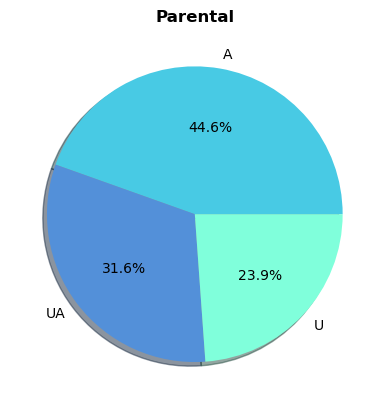

In [62]:
df2=normal_df['parental']
D1=df2.value_counts().index.tolist()
D=df2.value_counts()
colors = ['#48cae4','#5390d9','#80ffdb','#ffcc99']
plt.pie(D,labels=D1,autopct='%1.1f%%',shadow=True,colors=colors)
plt.title ("Parental",fontweight="bold")
plt.show()

In [63]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
# Assigning numerical values and storing in another column
normal_df['parental'] = labelencoder.fit_transform(normal_df['parental'])
normal_df

,budget,box_office,metascore,num_Rating,genre,parental
0,0.271094,2.281004,2.150469,2.965223,"Adventure,Animation,Comedy",1
1,-0.118225,-0.349691,0.721469,2.386674,"Adventure,Biography,Drama",1
2,0.314352,1.683251,0.845730,2.993588,"Action,Adventure,Animation",1
3,-0.074968,0.392998,1.529165,2.723763,"Drama,Sport",2
4,-0.111016,-0.455436,1.094252,0.980987,"Biography,Drama,History",2
...,...,...,...,...,...,...
3690,0.227836,0.526888,-1.328834,-0.401243,"Action,Adventure,Comedy",2
3691,-0.031710,-0.212880,-1.018182,-0.712556,"Drama,Music,Romance",2
3692,-0.046129,-0.034534,-1.825877,-0.582620,"Action,Comedy,Crime",1
3693,-0.072084,-0.386270,-0.086226,-0.524314,"Comedy,Fantasy,Musical",2


In [64]:
normal_df = pd.concat([normal_df.drop('genre', 1), normal_df['genre'].str.get_dummies(sep=",")], 1)
normal_df.insert(normal_df.shape[1], 'rating', target)

C:\Users\vsgok\AppData\Local\Temp\ipykernel_5908\3328898201.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  normal_df = pd.concat([normal_df.drop('genre', 1), normal_df['genre'].str.get_dummies(sep=",")], 1)
C:\Users\vsgok\AppData\Local\Temp\ipykernel_5908\3328898201.py:1: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  normal_df = pd.concat([normal_df.drop('genre', 1), normal_df['genre'].str.get_dummies(sep=",")], 1)


In [65]:
print(df.shape)

(3695, 4)


In [66]:
normal_df.head()

,budget,box_office,metascore,num_Rating,parental,Action,Adventure,Animation,Biography,Comedy,...,Musical,Mystery,Reality-TV,Romance,Sci-Fi,Sport,Thriller,War,Western,rating
0,0.271094,2.281004,2.150469,2.965223,1,0,1,1,0,1,...,0,0,0,0,0,0,0,0,0,8.1
1,-0.118225,-0.349691,0.721469,2.386674,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,8.1
2,0.314352,1.683251,0.845730,2.993588,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,8.1
3,-0.074968,0.392998,1.529165,2.723763,2,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,8.1
4,-0.111016,-0.455436,1.094252,0.980987,2,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,8.1


In [67]:
df=normal_df

## 2.5 Visualisation

### Using Box plot to visualize the distribution of dataframe

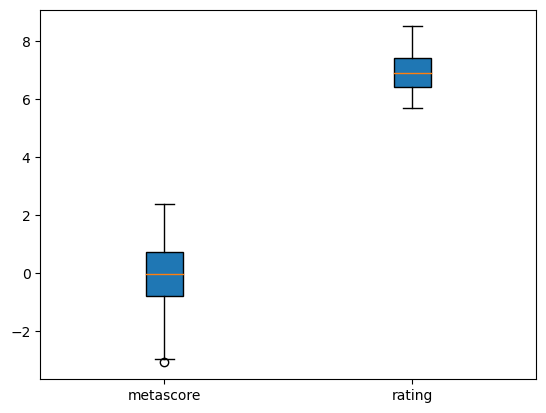

In [68]:
box_plot_data=[df['metascore'],df['rating']]
plt.boxplot(box_plot_data,patch_artist=True,labels=['metascore','rating'])
plt.show()

### Count plot

C:\Users\vsgok\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


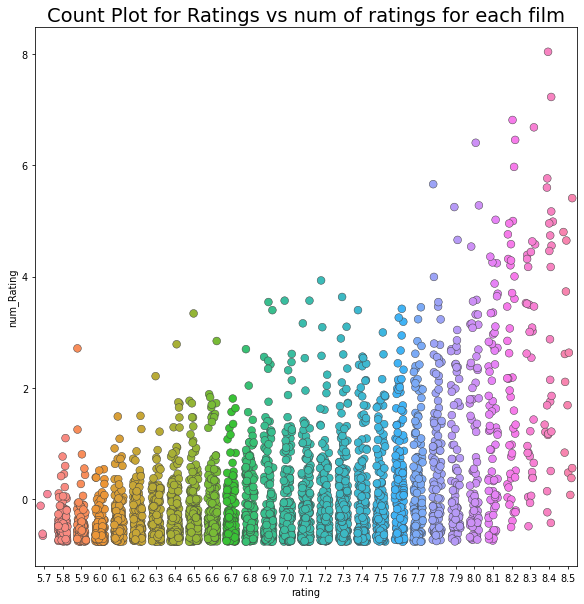

In [69]:
fig,ax=plt.subplots(figsize=(10,10),dpi=70)
sn.stripplot(df.rating,df.num_Rating,jitter=0.25, size=8, ax=ax, linewidth=.5)
plt.title('Count Plot for Ratings vs num of ratings for each film',fontsize=20)
plt.show()

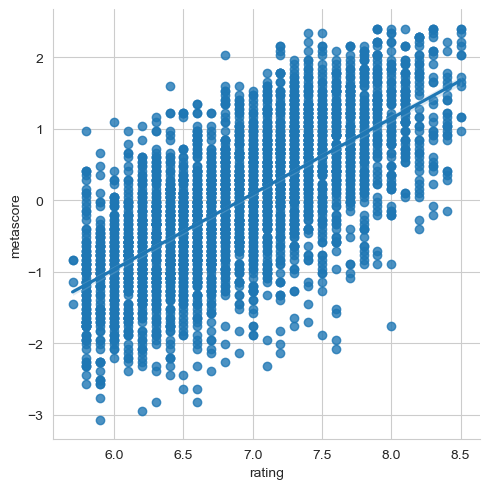

In [70]:
sn.set_style('whitegrid')
sn.lmplot(x ='rating', y ='metascore', data = df)
plt.show()

In [71]:
df.head()

,budget,box_office,metascore,num_Rating,parental,Action,Adventure,Animation,Biography,Comedy,...,Musical,Mystery,Reality-TV,Romance,Sci-Fi,Sport,Thriller,War,Western,rating
0,0.271094,2.281004,2.150469,2.965223,1,0,1,1,0,1,...,0,0,0,0,0,0,0,0,0,8.1
1,-0.118225,-0.349691,0.721469,2.386674,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,8.1
2,0.314352,1.683251,0.845730,2.993588,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,8.1
3,-0.074968,0.392998,1.529165,2.723763,2,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,8.1
4,-0.111016,-0.455436,1.094252,0.980987,2,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,8.1


## 3.  Choosing the right estimator/algorithm/model for the problem and fitting the model to make predictions.
- Now we've got our data as numbers and filled (no missing values)
- Different names for :
* `X` = features, feature variables, data.
* `y` = labels, targets, target variables.

### 3.1 Splitting the dataset into test and train
* Here the dataframe contributes 80% data to train_set and 20% to test_set

In [72]:
##Splitting the data
np.random.seed(42)
X = df.drop(["rating"], axis = 1)
y = df["rating"]
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.80, random_state=0)

### 3.2 Picking a machine learning model for prediction

Using Support Vector machine regressor ensemble model to predict the continuous data of the target variable

In [76]:
from sklearn.svm import SVR
from sklearn.metrics import r2_score
svr = SVR(kernel = 'rbf')
svr.fit(X_train, y_train)
print('R-squared: {:.2f}'.format(svr.score(X_train, y_train)))

R-squared: 0.75


# 4. Evaluating a machine learning model.

Three ways to evaluvate Scikit-learn models/estimators.
  1. Estimator's built-in `score()` method.
  2. The `scoring` parameter.

### 4.1 Evaluvating a model with the `score` method

In [77]:
svr_pred= svr.predict(X_test)
svr_pred = svr_pred.reshape(-1,1)
from sklearn import metrics
r2 = r2_score(y_test,svr_pred)
print(r2)

0.6962062413254857


### 4.2 Evaluvating a model using `scoring` parameter / `cross validation`

In [78]:
from sklearn.model_selection import cross_val_score
folds = KFold(n_splits = 10, shuffle = True, random_state = 100)
svr_cross_val_score =np.mean(cross_val_score(svr, X_train, y_train,scoring='r2', cv=folds))
svr_cross_val_score

0.6633075944306376

### 4.2.1 Regression model evaluation metrics
1. R squared. 
2. Mean Absolute Error.
3. Mean Squared Error.
4. Root Mean Squared Error.


#### R squared(R2)
* The R2 score is a metric that indicates how well your model performed, as opposed to the loss in terms of how many wells it performed. 

* R squared provides us with a baseline model against which to assess alternative models that none of the other measures do. We refer to the same thing in classification issues as a threshold, which is set at 0.5. In essence, R2 squared determines whether a regression line is superior to a mean line.

* R2 squared is hence sometimes known as the coefficient of determination or occasionally as the goodness of fit.

In [79]:
r2 = r2_score(y_test,svr_pred)
print(r2)

0.6962062413254857


#### Mean Absolute Error(MAE)
* The MAE is a relatively straightforward statistic that determines the absolute difference between the actual and anticipated values. We need to identify your model's MAE, which is essentially an error that the model committed and is known as a mistake. Now determine the discrepancy between the actual value and the anticipated value, which is an absolute error. However, we must first get the mean absolute of the whole dataset.
* Thus, add up all the mistakes and divide them by the overall number of observations. It's MAE, by the way. Since this is a loss, we also strive for a minimum MAE.

In [80]:
from sklearn.metrics import mean_absolute_error
print("MAE:",mean_absolute_error(y_test,svr_pred))

MAE: 0.288745404928962


#### Mean Squared Error(MSE)
* The most popular and straightforward statistic, MSE, has a little amount of variation in mean absolute error. The squared difference between the actual and anticipated values is what is meant by "mean squared error."

In [81]:
from sklearn.metrics import mean_squared_error
print("MSE:",mean_squared_error(y_test,svr_pred))

MSE: 0.1355831643425129


#### Root Mean Squared Error( RMSE)
* By its very name, RMSE makes it clear that it is a straightforward square root of mean squared error.

In [82]:
print("RMSE:",np.sqrt(mean_squared_error(y_test,svr_pred)))

RMSE: 0.3682161923958708


#### Root Mean Squared Log Error(RMSLE)
* The magnitude of error is slowed down by taking the RMSE metric's log. When you are creating a model without calling the inputs, the metric is quite beneficial. 
* The result will then be highly variable in that situation. To control this RMSE condition, we take the calculated RMSE error log and convert 

In [83]:
rmsle = np.sqrt(mean_squared_error(np.log1p(y_test), np.log1p(svr_pred)))
print("RMSLE:",rmsle)

RMSLE: 0.046626557788545415


In [84]:
lr = LinearRegression()
lr.fit(X_train, y_train)
print('R-squared: {:.4f}'.format(lr.score(X_train, y_train)))
print('R-squared: {:.4f}'.format(lr.score(X_test, y_test)))
lr_pred= lr.predict(X_test)
lr_pred = lr_pred.reshape(-1,1)
from sklearn import metrics
r2 = r2_score(y_test,lr_pred)
print(r2)
print("MAE:",mean_absolute_error(y_test,lr_pred))
print("MSE:",mean_squared_error(y_test,lr_pred))
print("RMSE:",np.sqrt(mean_squared_error(y_test,lr_pred)))
rmsle = np.sqrt(mean_squared_error(np.log1p(y_test), np.log1p(lr_pred)))
print("RMSLE:",rmsle)

R-squared: 0.6299
R-squared: 0.6305
0.6304504659155709
MAE: 0.3241354528831009
MSE: 0.1649299690391289
RMSE: 0.40611570892927656
RMSLE: 0.05114142999348349


In [85]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators = 180, random_state = 27)
rfr.fit(X_train, y_train)
print('R-squared: {:.4f}'.format(rfr.score(X_train, y_train)))
print('R-squared: {:.4f}'.format(rfr.score(X_test, y_test)))
rfr_pred= rfr.predict(X_test)
rfr_pred = rfr_pred.reshape(-1,1)
from sklearn import metrics
r2 = r2_score(y_test,rfr_pred)
print(r2)
print("MAE:",mean_absolute_error(y_test,rfr_pred))
print("MSE:",mean_squared_error(y_test,rfr_pred))
print("RMSE:",np.sqrt(mean_squared_error(y_test,rfr_pred)))
rmsle = np.sqrt(mean_squared_error(np.log1p(y_test), np.log1p(rfr_pred)))
print("RMSLE:",rmsle)

R-squared: 0.9511
R-squared: 0.6688
0.6687972240235951
MAE: 0.3021199819576005
MSE: 0.1478158096526839
RMSE: 0.38446821670026754
RMSLE: 0.04876857190653184
